In [1]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    os.chdir(os.path.abspath(os.path.join(os.path.abspath(os.path.dirname(__vsc_ipynb_file__)), os.pardir)))
    print("Working on local machine...")

Working on local machine...


In [2]:
# !pip install -r requirements.txt

In [3]:
import random
run_id = random.randint(10_000, 100_000)

# Configuration
config = {
    'in_channels': 3,           # Number of input channels
    'conv_layers': [(32, 3, 1), (64, 3, 1), (128, 3, 1), (256, 3, 1), (512, 3, 1), (1024, 3, 1), (1024, 3, 1)],
    'fc_layers': [512, 128],
    'lstm_hidden_size': 128,    # LSTM hidden size
    'lstm_layers': 4,           # Number of LSTM layers
    'leak': 0.2,                # Leaky ReLU leak
    'dropout': 0.7,             # Dropout rate
    'output_size': 2,           # Classification output
    'img_size': (64, 64),       # Input image size
    'batch_size': 32,           # Batch size
    'epochs': 300,              # Number of epochs
    'data_length': 1_000,       # Number of data points to consider
    'learning_rate': 0.001,     # Learning rate
    'data_filename': 'US.RANDOM.10.10.64.3.MONO'
}

print(f"Run ID: {run_id}")

Run ID: 39114


In [4]:
import torch
import json
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import torchvision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from livelossplot import PlotLosses

import seaborn as sns


In [5]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled = False
    return True

In [6]:
print(torch.version.cuda)

11.7


In [7]:
set_seed(42)

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available! Using CPU!")

Cuda installed! Running on GPU!


In [8]:
# Custom dataset to handle image and target loading
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

(1000, 2)
                                                       0    1
15546  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  1.0
4740   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.0
2221   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  1.0
18671  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.0
14375  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.0


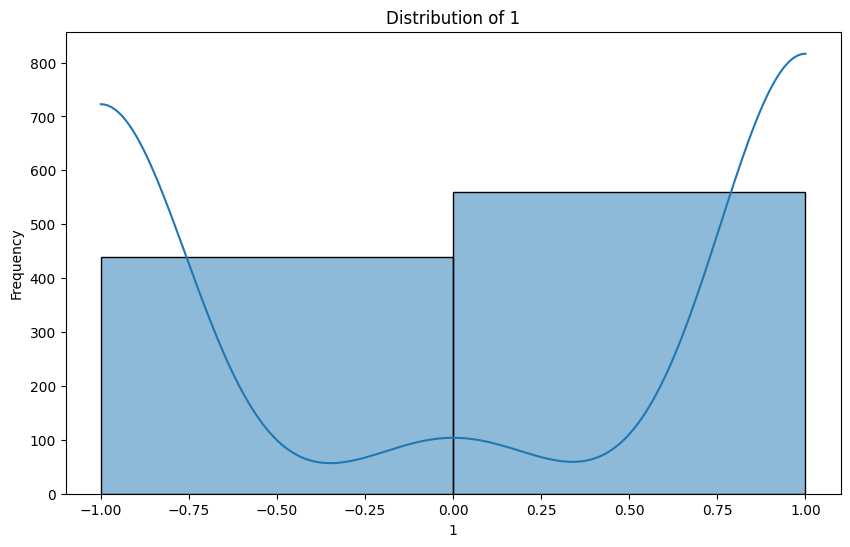

In [9]:
# Load the data
filename = config["data_filename"]
full_data = np.load(f"./data/processed/{filename}/data.npy", allow_pickle=True)   # noqa

full_data = pd.DataFrame(full_data)

full_data = full_data.sample(n=config["data_length"] if config["data_length"] != None else len(full_data))

print(full_data.shape)
print(full_data.head())
full_data.dropna(inplace=True)

# Plot the distribution of each column (except the image column)
for col in full_data.columns[1:]:
    plt.figure(figsize=(10, 6))
    sns.histplot(full_data[col], bins=config["output_size"], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [10]:
data = full_data.to_numpy()
print(data.shape)

(1000, 2)


In [11]:
def train_val_test_split(data, train_size=0.7, val_size=0.2):
    train_size = int(len(data) * train_size)
    val_size = int(len(data) * val_size)
    test_size = len(data) - train_size - val_size
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data

In [12]:
train_data, val_data, test_data = train_val_test_split(data)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

train_images = train_data[:, 0]
train_targets = np.asarray(train_data[:, 1:], dtype=np.int64)

val_images = val_data[:, 0]
val_targets = np.asarray(val_data[:, 1:], dtype=np.int64)

test_images = test_data[:, 0]
test_targets = np.asarray(test_data[:, 1:], dtype=np.int64)

(700, 2)
(200, 2)
(100, 2)


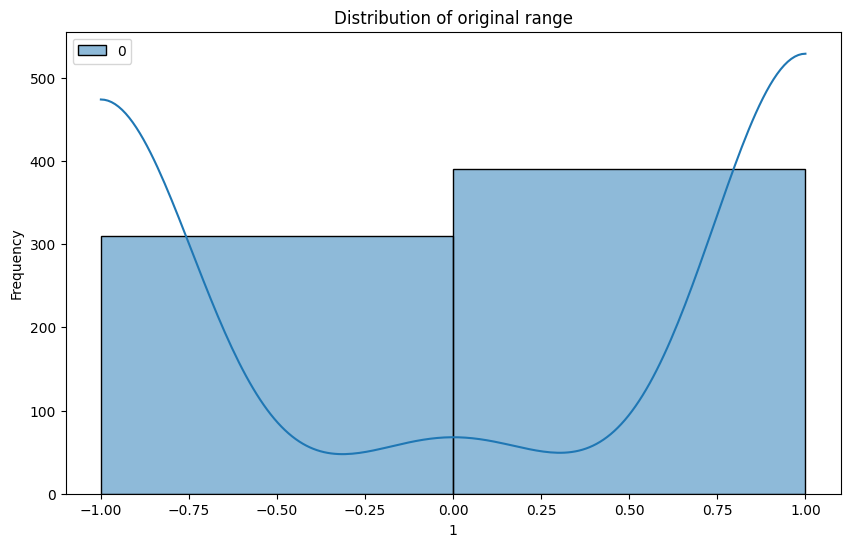

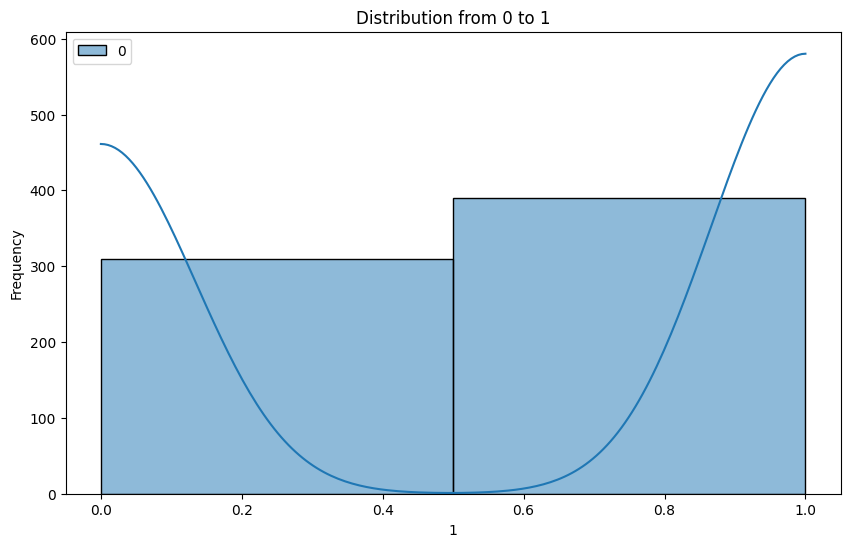

In [13]:
def quantize_labels(targets, num_classes=2):
    """
    Quantize targets from the range [-1, 1] to the integer range [0, num_classes-1].

    Args:
        targets (numpy.ndarray): Array of targets in the range [-1, 1].
        num_classes (int): Number of classes to quantize to.

    Returns:
        numpy.ndarray: Quantized targets in the integer range [0, num_classes-1].
    """
    # Scale the range from [-1, 1] to [0, 1]
    scaled_targets = (targets + 1) / 2

    # Quantize to the range [0, num_classes-1]
    quantized_targets = np.floor(scaled_targets * num_classes).astype(np.int64)

    # Ensure targets are within the range [0, num_classes-1]
    quantized_targets = np.clip(quantized_targets, 0, num_classes-1)

    return quantized_targets

plt.figure(figsize=(10, 6))
sns.histplot(train_targets, bins=config["output_size"], kde=True)
plt.title(f'Distribution of original range')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

train_targets = quantize_labels(train_targets, num_classes=config['output_size'])
val_targets = quantize_labels(val_targets, num_classes=config['output_size'])
test_targets = quantize_labels(test_targets, num_classes=config['output_size'])

plt.figure(figsize=(10, 6))
sns.histplot(train_targets, bins=config["output_size"], kde=True)
plt.title(f'Distribution from 0 to {config["output_size"]-1}')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

In [14]:
from torchvision.transforms.functional import pad
from torchvision import transforms
from PIL import Image
import numpy as np
import numbers

def get_padding(image):    
    w, h = image.size
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    return padding

class SquarePad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        img = Image.fromarray(img)
        return pad(img, get_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

In [15]:
# Transformations for the images
transform = transforms.Compose([
    SquarePad(),  # Make the image square by padding
    transforms.Resize((64, 64)),  # Resize
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

# Create datasets and dataloaders
trainset = ImageDataset(train_images, train_targets, transform=transform)
valset = ImageDataset(val_images, val_targets, transform=transform)
testset = ImageDataset(test_images, test_targets, transform=transform)

trainloader = DataLoader(trainset, batch_size=config["batch_size"], shuffle=True)
valloader = DataLoader(valset, batch_size=config["batch_size"], shuffle=False)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [16]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

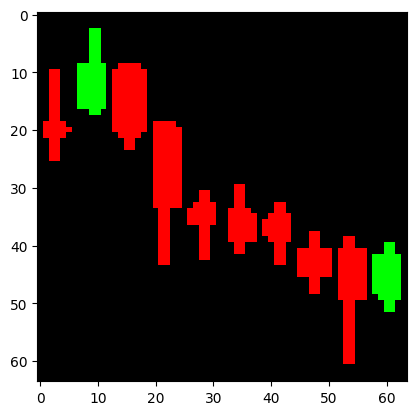

In [17]:
# get some random training images
images, labels = trainloader.dataset[0]

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

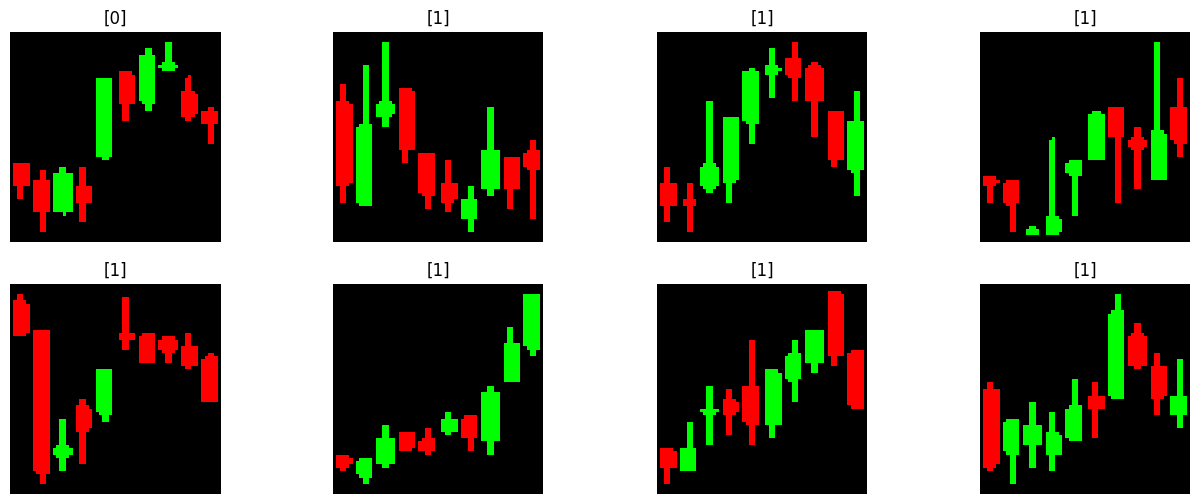

In [18]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.images, trainset.targets)

# plot images
plt.figure(figsize=(16, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [19]:
class FlexibleNet(nn.Module):
    def __init__(self, config):
        super(FlexibleNet, self).__init__()
        layers = []
        in_channels = config['in_channels']
        
        # Define the convolutional layers with strided convolutions instead of pooling
        for idx, (out_channels, kernel_size, padding) in enumerate(config['conv_layers']):
            stride = 2 if idx % 2 == 1 else 1  # Apply strided convolution every 2 layers to reduce spatial dimensions
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(negative_slope=config['leak']))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Flatten()

        # Calculate the size of the flattened features after all convolutions and pooling layers
        with torch.no_grad():
            self.feature_dim = self._calculate_feature_dim(config['img_size'], config['in_channels'])

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=config['lstm_hidden_size'], num_layers=config['lstm_layers'], batch_first=True)

        fc_layers = []
        input_dim = config['lstm_hidden_size']
        for hidden_size in config['fc_layers']:
            fc_layers.append(nn.Linear(input_dim, hidden_size))
            fc_layers.append(nn.BatchNorm1d(hidden_size))
            fc_layers.append(nn.LeakyReLU(negative_slope=config['leak']))
            fc_layers.append(nn.Dropout(config['dropout']))
            input_dim = hidden_size

        fc_layers.append(nn.Linear(input_dim, config['output_size']))
        self.fc_layers = nn.Sequential(*fc_layers)

    def _calculate_feature_dim(self, img_size, in_channels):
        x = torch.randn(1, in_channels, *img_size)
        x = self.conv_layers(x)
        x = self.flatten(x)
        return x.shape[1]

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = x.view(batch_size, 1, -1)  # Adjust the input size for the LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get the output of the last LSTM cell
        x = self.fc_layers(x)
        return x

In [20]:
class PercentageDistanceLoss(nn.Module):
    def __init__(self, threshold=0.1):
        super(PercentageDistanceLoss, self).__init__()
        self.threshold = threshold

    def forward(self, outputs, targets):
        max_distance = 2.0
        distance = torch.abs(outputs - targets)
        percentage_distance = distance / max_distance

        # Calculate the mean percentage distance error
        mean_percentage_distance = torch.mean(percentage_distance)

        # Calculate the proportion of outputs within the threshold
        within_threshold = (distance <= self.threshold).float()
        proportion_within_threshold = len(within_threshold[within_threshold == 1]) / len(within_threshold)

        # Calculate the total loss as the mean percentage distance error
        # combined with the inverse proportion of outputs within the threshold
        total_loss = mean_percentage_distance + (1 - proportion_within_threshold)

        return total_loss, proportion_within_threshold

def rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))


def print_examples(targets, predictions, num_examples=5):
    print("Samples (Target -> Prediction):")
    for i in range(min(num_examples, len(targets))):
        correct = np.allclose(targets[i], predictions[i], atol=0.1)
        print(f"{targets[i]} -> {predictions[i]} {'OK' if correct else ''}")
    
    # Calculate and print relevant statistics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')

    print("\nStatistics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [21]:
def save_model(model, config, val_accuracy, run_id, path='./deep_learning/models/'):
    # Find the pth file from the same run_id
    files = os.listdir(path)
    for file in files:
        if str(run_id) in file:
            os.remove(os.path.join(path, file))

    torch.save(model.state_dict(), f'./deep_learning/models/{run_id}.{config["data_filename"]}.{config["output_size"]}.{val_accuracy*100:.0f}.pth')
    json.dump(config, open(f'./deep_learning/models/{run_id}.{config["data_filename"]}.{config["output_size"]}.{val_accuracy*100:.0f}.json', 'w'))

In [22]:
# Initialize the model, loss function, optimizer, and scaler
model = FlexibleNet(config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
scaler = GradScaler()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Wrap the model with DataParallel to enable multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    print(f"Device name: {device}")
    # model = nn.DataParallel(model)

total_params = sum(
	param.numel() for param in model.parameters()
)
print(f'{total_params:,} total parameters.')

Using 2 GPUs
Device name: cuda
49,883,010 total parameters.


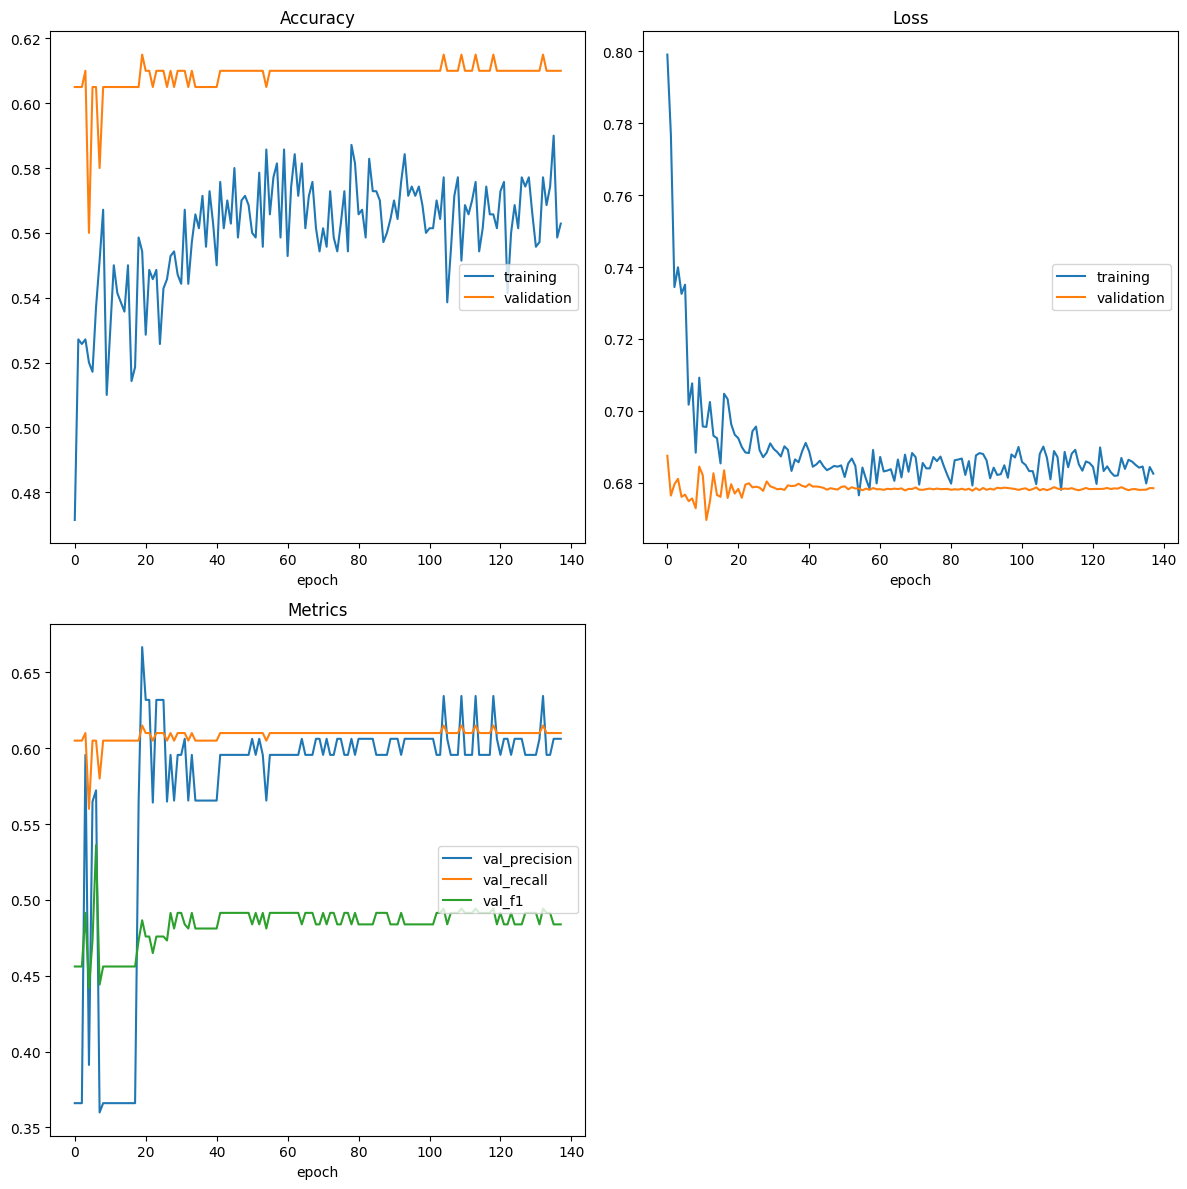

Epoch 138/300, Train Loss: 0.6825, Train Accuracy: 0.5629, Validation Loss: 0.6784, Validation Accuracy: 0.6100
Samples (Target -> Prediction):
1 -> 1 OK
0 -> 1 
1 -> 1 OK
0 -> 1 
1 -> 1 OK
1 -> 1 OK
0 -> 1 
1 -> 1 OK
1 -> 1 OK
0 -> 1 

Statistics:
Accuracy: 0.6100
Precision: 0.6062
Recall: 0.6100
F1 Score: 0.4839


KeyboardInterrupt: 

In [23]:
# Training loop
epochs = config['epochs']
best_val_loss = float('inf')

# Initialize livelossplot
liveloss = PlotLosses(outputs=['MatplotlibPlot'], groups={'Loss': ['loss', 'val_loss'], 'Accuracy': ['acc', 'val_acc'], 'Metrics': ['val_precision', 'val_recall', 'val_f1']})

for epoch in range(epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in trainloader:
        images, targets = images.to(device), targets.squeeze().to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_val_targets = []
    all_val_predictions = []

    with torch.no_grad():
        for images, targets in valloader:
            images, targets = images.to(device), targets.squeeze().to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_val_targets.extend(targets.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss = val_loss / len(valloader.dataset)
    val_accuracy = correct / total

    # Calculate additional metrics
    val_precision = precision_score(all_val_targets, all_val_predictions, average='weighted')
    val_recall = recall_score(all_val_targets, all_val_predictions, average='weighted')
    val_f1 = f1_score(all_val_targets, all_val_predictions, average='weighted')

    # Log the values
    logs['loss'] = train_loss  # Minimize
    logs['acc'] = train_accuracy  # Maximize
    logs['val_loss'] = val_loss  # Minimize
    logs['val_acc'] = val_accuracy  # Maximize

    logs['val_precision'] = val_precision  # Maximize
    logs['val_recall'] = val_recall  # Maximize
    logs['val_f1'] = val_f1  # Maximize

    # Send the logs to livelossplot
    liveloss.update(logs)
    liveloss.send()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Print example predictions
    print_examples(all_val_targets, all_val_predictions, num_examples=10)

    # Step the scheduler
    scheduler.step(val_loss)

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(model, config, val_accuracy, run_id)
        print(f"Saving model with accuracy: {val_accuracy:.2f}")

print('Finished Training')

In [ ]:
# Load the best model
filename = '77863.US.RANDOM.10.4.64.3.MONO.2.55'

config = json.load(open(f'./deep_learning/models/{filename}.json'))
model = FlexibleNet(config).to(device)
model.load_state_dict(torch.load(f'./deep_learning/models/{filename}.pth'))

# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, targets in testloader:
        images, targets = images.to(device), targets.squeeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_loss = test_loss / len(testloader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")